In [5]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
from data_management.split_raw_data import TRAIN_NAME
from data_management.get_counts import FileResult, ANALYSIS_NAME
from data_management.dataset_file import DatasetFile
from coqlspclient.coq_structs import TermType
import json

In [6]:
DATA_SPLIT_LOC = "/home/ubuntu/coq-modeling/raw-data/data-points-split/"

In [7]:
file_loc = os.path.join(DATA_SPLIT_LOC, ANALYSIS_NAME)
file_result = FileResult.load(file_loc)

### Examples by Sentence Type

In [8]:
train_loc = os.path.join(DATA_SPLIT_LOC, TRAIN_NAME)
examples: list[tuple[TermType, str]] = []
class Found(Exception):
    pass
for term_type, term_count in file_result.avail_aggregator.table_counts.type_freqs.items():
    try:
        for file_dir in os.listdir(train_loc):
            file_dir_loc = os.path.join(train_loc, file_dir)
            dset_file = DatasetFile.from_directory(file_dir_loc)
            for premise in dset_file.avail_premises:
                if premise.sentence_type == term_type:
                    examples.append((term_type, premise.text))
                    raise Found
    except Found:
        pass





/root/.opam/default/lib/coq/theories/Init/Logic.v:65 Not Sentence: Notation "A /\ B" := (and A B) : type_scope
/root/.opam/default/lib/coq/theories/Init/Logic.v:92 Not Sentence: Notation "A \/ B" := (or A B) : type_scope
/root/.opam/default/lib/coq/theories/Init/Logic.v:379 Not Sentence: Notation "x = y :> A" := (@eq A x y) : type_scope
/root/.opam/default/lib/coq/theories/Init/Datatypes.v:226 Not Sentence: Notation "x * y" := (prod x y) : type_scope
/root/.opam/default/lib/coq/theories/Init/Specif.v:910 Not Sentence: Notation "{ A } + { B }" := (sumbool A B) : type_scope
/root/.opam/default/lib/coq/theories/Init/Specif.v:926 Not Sentence: Notation "A + { B }" := (sumor A B) : type_scope
/root/.opam/default/lib/coq/theories/Init/Nat.v:52 Not Sentence: Notation "n + m" := (add n m) : nat_scope
/root/.opam/default/lib/coq/theories/Init/Nat.v:64 Not Sentence: Notation "n * m" := (mul n m) : nat_scope
/root/.opam/default/lib/coq/theories/Init/Nat.v:76 Not Sentence: Notation "n - m" := (sub

In [9]:
for example_type, example_str in examples:
    print(f"{example_type.name}: {example_str}")

THEOREM: Theorem proj1 : A /\ B -> A.
DEFINITION: Definition not (A:Prop) := A -> False.
LEMMA: Lemma iff_and : forall A B : Prop, (A <-> B) -> (A -> B) /\ (B -> A).
NOTATION: Notation "'if' c 'is' p 'then' u 'else' v" := (match c with p => u | _ => v end) (at level 200, p pattern at level 100).
FIXPOINT: Fixpoint nb_digits d := match d with | Nil => O | D0 d | D1 d | D2 d | D3 d | D4 d | D5 d | D6 d | D7 d | D8 d | D9 d | Da d | Db d | Dc d | Dd d | De d | Df d => S (nb_digits d) end.
VARIANT: Variant uint := UIntDecimal (u:Decimal.uint) | UIntHexadecimal (u:Hexadecimal.uint).
TACTIC: Ltac exfalso := elimtype False.
INDUCTIVE: Inductive True : Prop := I : True.
SCHEME: Scheme Acc_inv_dep := Induction for Acc Sort Prop.
OTHER: CoFixpoint bind {A B: Type} (d: delay A) (f: A -> delay B) := match d with | now v => later (f v) | later d' => later (bind d' f) end.
INSTANCE: Global Instance StrictOrder_Asymmetric `(StrictOrder R) : Asymmetric R.
CLASS: Class subrelation (R R' : crelation A) 

### Available Premises

In [23]:
def plot_avg_premises(avg_results: dict[str, float],
                      ax_title: str) -> None:
    labels: list[str] = []
    avgs: list[float] = []
    for premise_type_name, avg in avg_results.items():
        print(f"  - {premise_type_name}: {avg}")
        formatted_avg = "{:.2f}".format(avg)
        label = f"{premise_type_name}: {formatted_avg}"
        labels.append(label)
        avgs.append(avg)
    fig, ax = plt.subplots()
    fig.suptitle(ax_title)
    #fig.set_title(ax_title)
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    wedges, text = ax.pie(avgs)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    avg_sum = sum(v for k, v in avg_results.items())
    for i, wedge in enumerate(wedges):
        ang_diff = wedge.theta2 - wedge.theta1
        ang = (ang_diff / 2.) + wedge.theta1
        piece_of_pie = avgs[i] / avg_sum
        if piece_of_pie < 0.01:
            continue 
        rad_ang = np.deg2rad(ang)
        x = np.cos(rad_ang)
        y = np.sin(rad_ang)
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        

Average # of Premises Available by Type:
  - THEOREM: 354.77748086484445
  - DEFINITION: 766.8849407195116
  - LEMMA: 1382.496977613979
  - NOTATION: 525.2461816610457
  - FIXPOINT: 136.8109382062375
  - VARIANT: 7.182291847753202
  - TACTIC: 175.60101524355414
  - INDUCTIVE: 72.23775275541273
  - SCHEME: 3.2566370802310622
  - OTHER: 13.60288281486706
  - INSTANCE: 140.00467389522726
  - CLASS: 30.41607601412599
  - RECORD: 12.109893657707953
  - COROLLARY: 2.2060934481028753
  - REMARK: 2.395065836855725
  - FACT: 0.09031396059225852
  - PROPOSITION: 0.9264147101042561


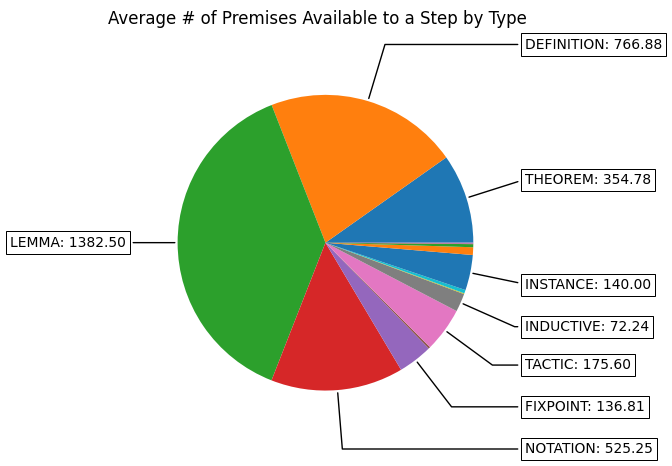

In [24]:
avg_file_results = file_result.avail_aggregator.compute()
print("Average # of Premises Available by Type:")
plot_avg_premises(avg_file_results, "Average # of Premises Available to a Step by Type")

### Positive Premises

Step Needs Premise Freq: 0.3258415246534314
Steps w/ pos prem & period: 0.05827566232736807
Steps w/ pos prem term type freqs:
{
  "NOTATION": 0.19664034633090455,
  "INDUCTIVE": 0.1816560470717356,
  "TACTIC": 0.08851864272430719,
  "OTHER": 0.13885247400993872,
  "LEMMA": 0.2231944148044267,
  "DEFINITION": 0.20801195085515686,
  "THEOREM": 0.07687265632145361,
  "FIXPOINT": 0.07228438157373251,
  "CLASS": 0.15382152983140757,
  "VARIANT": 0.0002286515655010518,
  "RECORD": 0.015929392396573275,
  "FACT": 0.0034907472333160577,
  "COROLLARY": 0.0027438187860126216,
  "INSTANCE": 0.001021310325904698,
  "SCHEME": 0.0005487637572025243,
  "REMARK": 0.0003963293802018231,
  "PROPOSITION": 0.008353403859638425
}
  - NOTATION: 0.19664034633090455
  - INDUCTIVE: 0.1816560470717356
  - TACTIC: 0.08851864272430719
  - OTHER: 0.13885247400993872
  - LEMMA: 0.2231944148044267
  - DEFINITION: 0.20801195085515686
  - THEOREM: 0.07687265632145361
  - FIXPOINT: 0.07228438157373251
  - CLASS: 0.153

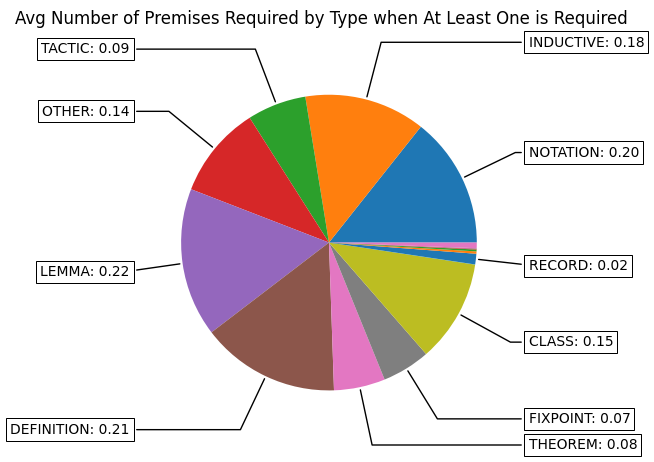

In [25]:
print(file_result.pos_aggregator)
pos_premise_avgs = file_result.pos_aggregator.compute()
plot_avg_premises(pos_premise_avgs,
                  "Avg Number of Premises Required by Type when At Least One is Required")


In [13]:
sum(file_result.pos_aggregator.table_counts.type_freqs.values())

90043

In [14]:
sum(file_result.avail_aggregator.table_counts.type_freqs.values()) / file_result.num_steps

3626.245630330153